In [1]:
# 21-1. 프로젝트 : 개선된 U-Net 모델 만들기


U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 어느 정도 동작하는 것 같긴 하지만 좀 더 개선할 여지도 보일 것입니다.

2018년에 U-Net++라는 논문이 나왔습니다. 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다. 논문은 2020년에 한 번 업그레이드가 되었네요.
- [U-Net++: v1](https://arxiv.org/abs/1807.10165)
- [U-Net++: v2](https://arxiv.org/abs/1912.05074)

모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다. 오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다. 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU 값을 비교해 보면 될 것입니다.
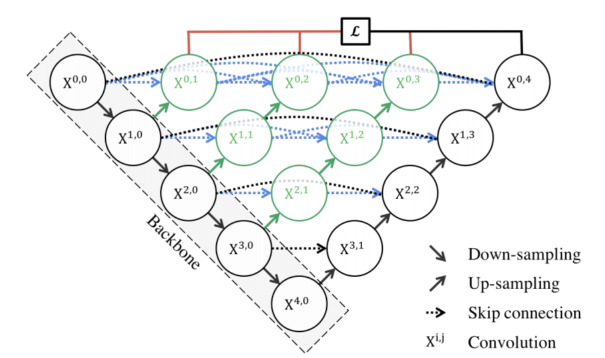
참고할 수 있는 코드는 아래에 있습니다. 다행히도 keras로 구현되어 있습니다.
- [U-Net++:Github](https://github.com/MrGiovanni/UNetPlusPlus)

코드 중에서 가장 중요한 부분도 알려드리자면 [여기:build_xnet](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/builder.py#L12)입니다. 논문에서 제시하는 수식과 함께 참고하세요.
![H와 u와 []가 무엇인지 주목하세요](attachment:image-2.png)
코드 중 ```up_block```으로는 두 가지 방식을 사용하고 있네요. [Transpose2D_block](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L53)과 [Upsample2D_block](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L28)인데요. 둘 중 어느 것을 사용해도 좋습니다.

또 한 가지 주의해야 할 점은 Loss를 조금 다르게 구현해야 한다는 점입니다. binary cross-entropy와 dice coefficient를 사용한다고 하는데요. [dice_coef](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/helper_functions.py#L37)에 구현된 dice coefficient를 참고해 보세요.
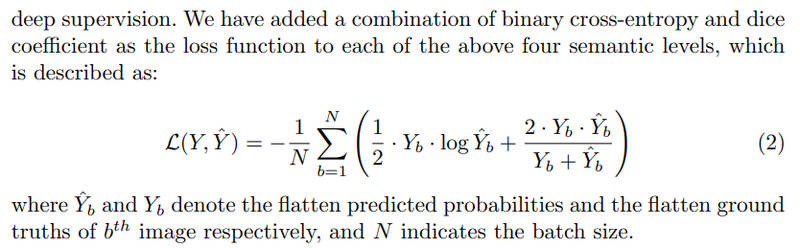

프로젝트 진행에 필요한 주요 라이브러리 버전 체크를 해봅시다.

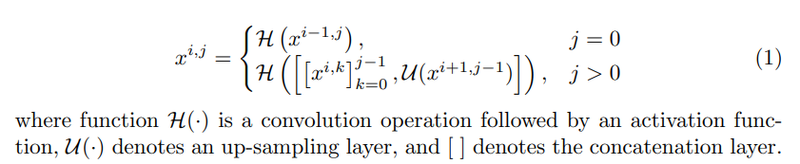

In [2]:
import tensorflow as tf
import numpy as np
import PIL
import skimage
import albumentations

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.6.0
1.21.4
8.3.2
0.18.3
1.1.0


#### Step 1. KITTI 데이터셋 수집과 구축
다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다. 그러니 배치 사이즈를 적절히 줄여서 설정하시기를 권합니다.



슝=3


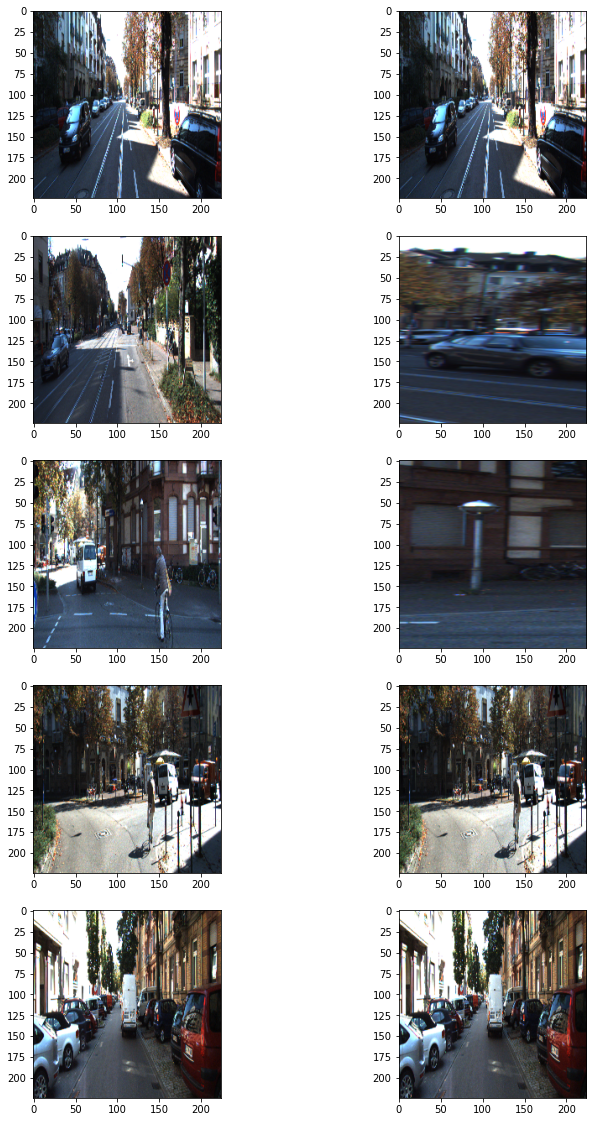

In [3]:
# 데이터 로더(data loader) 만들기

#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize
# imgaug의 Sometimes()와 유사한 기능
def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
    return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Epoch 1/100
11/11 [==============================] - 132s 6s/step - loss: 13.2945 - val_loss: 12.7447
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 12.3019 - val_loss: 11.7826
Epoch 3/100
11/11 [==============================] - 12s 1s/step - loss: 11.3653 - val_loss: 10.8693
Epoch 4/100
11/11 [==============================] - 12s 1s/step - loss: 10.4690 - val_loss: 10.0766
Epoch 5/100
11/11 [==============================] - 12s 1s/step - loss: 9.7253 - val_loss: 9.3434
Epoch 6/100
11/11 [==============================] - 12s 1s/step - loss: 9.0061 - val_loss: 8.7175
Epoch 7/100
11/11 [==============================] - 12s 1s/step - loss: 8.3799 - val_loss: 8.0928
Epoch 8/100
11/11 [==============================] - 12s 1s/step - loss: 7.8193 - val_loss: 7.6382
Epoch 9/100
11/11 [==============================] - 12s 1s/step - loss: 7.3259 - val_loss: 7.1254
Epoch 10/100
11/11 [==============================] - 13s 1s/step - loss: 6.8738 - val_loss: 6.7062


Epoch 82/100
11/11 [==============================] - 35s 2s/step - loss: 0.9621 - val_loss: 1.0020
Epoch 83/100
11/11 [==============================] - 15s 1s/step - loss: 0.9442 - val_loss: 0.9956
Epoch 84/100
11/11 [==============================] - 12s 1s/step - loss: 0.9443 - val_loss: 1.0034
Epoch 85/100
11/11 [==============================] - 11s 954ms/step - loss: 0.9404 - val_loss: 0.9676
Epoch 86/100
11/11 [==============================] - 11s 1s/step - loss: 0.9274 - val_loss: 0.9825
Epoch 87/100
11/11 [==============================] - 13s 1s/step - loss: 0.9089 - val_loss: 0.9773
Epoch 88/100
11/11 [==============================] - 13s 1s/step - loss: 0.9174 - val_loss: 0.9577
Epoch 89/100
11/11 [==============================] - 12s 1s/step - loss: 0.9017 - val_loss: 0.9468
Epoch 90/100
11/11 [==============================] - 11s 923ms/step - loss: 0.8900 - val_loss: 0.9216
Epoch 91/100
11/11 [==============================] - 10s 916ms/step - loss: 0.8785 - val_loss

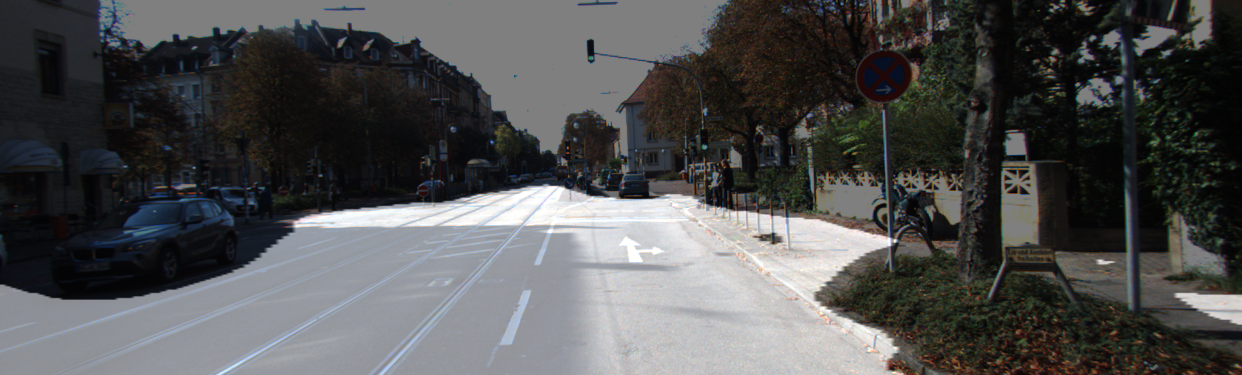

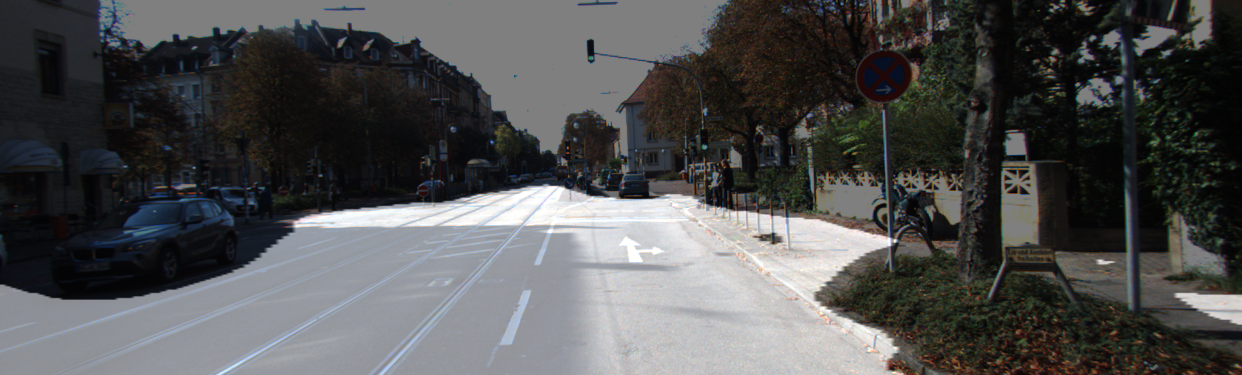

IoU : 0.854593


0.8545931014944401

In [4]:
# 모델 구조 만들기

# def build_model(input_shape=(224, 224, 3)):
#     model = None
#     # TODO: input_shape에 따라 U-Net을 만들어주세요
#     # 이때 model은 fully convolutional해야 합니다.
#     from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
#     from tensorflow.keras.models import Model
#     from tensorflow.keras import regularizers
    
#     inputs = Input(input_shape)
    
#     # L2 regularization 설정
#     l2_reg = regularizers.l2(0.001)
    
#     # ================================
#     # Encoder (Contracting Path)
#     # ================================
    
#     # Level 1: 224x224
#     conv1 = Conv2D(64, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # 112x112
    
#     # Level 2: 112x112
#     conv2 = Conv2D(128, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  # 56x56
    
#     # Level 3: 56x56
#     conv3 = Conv2D(256, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(conv3)
#     drop3 = Dropout(0.3)(conv3)  # Dropout 추가
#     pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)  # 28x28
    
#     # Level 4: 28x28
#     conv4 = Conv2D(512, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(pool3)
#     conv4 = Conv2D(512, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(conv4)
#     drop4 = Dropout(0.4)(conv4)  # Dropout 강화
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)  # 14x14
    
#     # Bottleneck: 14x14
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(pool4)
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(conv5)
#     drop5 = Dropout(0.5)(conv5)  # 기존 유지
    
#     # ================================
#     # Decoder (Expansive Path)
#     # ================================
    
#     # Level 4: 14x14 -> 28x28
#     up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same', 
#                           kernel_regularizer=l2_reg)(drop5)
#     merge6 = concatenate([drop4, up6], axis=3)  # Skip connection
#     conv6 = Conv2D(512, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(merge6)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(conv6)
#     drop6 = Dropout(0.3)(conv6)  # 디코더에 Dropout 추가
    
#     # Level 3: 28x28 -> 56x56
#     up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same', 
#                           kernel_regularizer=l2_reg)(drop6)
#     merge7 = concatenate([drop3, up7], axis=3)  # Skip connection (drop3 사용)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(merge7)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(conv7)
#     drop7 = Dropout(0.2)(conv7)  # 디코더에 Dropout 추가
    
#     # Level 2: 56x56 -> 112x112
#     up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same', 
#                           kernel_regularizer=l2_reg)(drop7)
#     merge8 = concatenate([conv2, up8], axis=3)  # Skip connection
#     conv8 = Conv2D(128, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(merge8)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(conv8)
    
#     # Level 1: 112x112 -> 224x224
#     up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same', 
#                           kernel_regularizer=l2_reg)(conv8)
#     merge9 = concatenate([conv1, up9], axis=3)  # Skip connection
#     conv9 = Conv2D(64, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(merge9)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(conv9)
#     conv9 = Conv2D(2, 3, activation='relu', padding='same', 
#                    kernel_initializer='he_normal', kernel_regularizer=l2_reg)(conv9)
    
#     # Output layer: 224x224x1 (binary segmentation)
#     conv10 = Conv2D(1, 1, activation='sigmoid', kernel_regularizer=l2_reg)(conv9)
    
#     model = Model(inputs=inputs, outputs=conv10)
#     return model
def build_model(input_shape=(224, 224, 3)):
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
    from tensorflow.keras.models import Model
    from tensorflow.keras import regularizers
    
    inputs = Input(input_shape)
    
    # ================================
    # Encoder (Contracting Path)
    # ================================
    
    # Level 1: 224x224
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # 112x112
    
    # Level 2: 112x112
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(conv2)
    conv2_drop = Dropout(0.2)(conv2)  # 정칙화 추가
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_drop)  # 56x56
    
    # Level 3: 56x56
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(conv3)
    conv3_drop = Dropout(0.3)(conv3)  # 정칙화 추가
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_drop)  # 28x28
    
    # Level 4: 28x28
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)  # 14x14
    
    # Bottleneck: 14x14
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # ================================
    # Decoder (Expansive Path) 
    # ================================
    
    # Level 4: 14x14 -> 28x28
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same',
                         kernel_regularizer=regularizers.l2(0.001))(drop5)
    merge6 = concatenate([conv4, up6], axis=3)  # 원래 conv4 사용 (drop 전)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(conv6)
    conv6_drop = Dropout(0.3)(conv6)  # 정칙화 추가
    
    # Level 3: 28x28 -> 56x56
    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same',
                         kernel_regularizer=regularizers.l2(0.001))(conv6_drop)
    merge7 = concatenate([conv3, up7], axis=3)  # 원래 conv3 사용 (drop 전)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(conv7)
    conv7_drop = Dropout(0.2)(conv7)  # 정칙화 추가
    
    # Level 2: 56x56 -> 112x112
    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same',
                         kernel_regularizer=regularizers.l2(0.001))(conv7_drop)
    merge8 = concatenate([conv2, up8], axis=3)  # 원래 conv2 사용 (drop 전)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(conv8)
    
    # Level 1: 112x112 -> 224x224
    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same',
                         kernel_regularizer=regularizers.l2(0.001))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)  # 원래 conv1 사용
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal',
                   kernel_regularizer=regularizers.l2(0.001))(conv9)
    
    # Output layer: 224x224x1 (binary segmentation)
    conv10 = Conv2D(1, 1, activation='sigmoid',
                    kernel_regularizer=regularizers.l2(0.001))(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)
    return model

# 모델 생성 및 확인
if __name__ == "__main__":
    model = build_model()
    model.summary()
    
    print("정칙화가 적용된 U-Net 모델 (크기 호환 문제 해결)")
    print("적용된 정칙화:")
    print("- L2 regularization (0.001) 모든 레이어에 적용")
    print("- Dropout: 인코더와 디코더에 적절히 배치")
    print("- Skip connection은 dropout 적용 전 feature map 사용")

# 모델 학습하기

model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model1 = build_model()
model1.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model1.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model1.save(model_path)  #학습한 모델을 저장해 주세요.

# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
# model_path = dir_path + '/seg_model_unet.h5' 

# model = tf.keras.models.load_model(model_path)

def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.
get_output(
     model1, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

def calculate_iou_score(target, prediction):
    intersection = np.sum(prediction * target)# intersection을 구하는 코드를 작성해주세요.
    union = np.sum(prediction) + np.sum(target) - intersection# Union을 구하는 코드를 작성해주세요.
    iou_score = float(intersection) / float(union)# iou 스코어를 구하되 결과값을 float로 만들어주세요!
    print('IoU : %f' % iou_score )
    return iou_score

def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model1, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

#### Step 2. U-Net++ 모델의 구현
U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다. 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.



In [7]:
'''
메모리 부족(OOM) 오류가 발생했습니다! 
U-Net++는 nested skip connections 때문에 일반 U-Net보다 메모리를 훨씬 많이 사용하기 때문
'''
# 기존 augmentation 함수들은 그대로 사용
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

# 🔥 여기서 batch_size=4만 추가하면 됩니다!
train_generator = KittiGenerator(
    dir_path, 
    batch_size=4,  # ✅ 16 → 4로 변경 (메모리 75% 절약!)
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    batch_size=4,  # ✅ 16 → 4로 변경 (메모리 75% 절약!)
    augmentation=test_preproc,
    is_train=False
)


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, concatenate, Activation, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

# ================================
# Loss Functions (Based on official helper_functions.py)
# ================================

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Dice coefficient based on official UNet++ implementation
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    """Dice loss"""
    return 1 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    """
    Combined Binary Cross-Entropy and Dice Loss
    Based on the paper's equation (2) and official implementation
    """
    # Flatten for computation
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # Binary Cross-Entropy: -1/N * Σ(1/2 * y * log(ŷ))
    bce = K.binary_crossentropy(y_true_f, y_pred_f)
    bce = K.mean(bce) * 0.5  # 1/2 factor from paper
    
    # Dice coefficient: 2 * y * ŷ / (y + ŷ)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_term = (2. * intersection + 1e-6) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-6)
    
    # Combined loss as in equation (2)
    loss = bce + (1 - dice_term)
    return loss

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    """Jaccard (IoU) loss - alternative metric"""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return 1 - jaccard

def bce_jaccard_loss(y_true, y_pred):
    """Combined BCE and Jaccard loss (alternative to dice)"""
    return K.binary_crossentropy(y_true, y_pred) + jaccard_loss(y_true, y_pred)

# ================================
# Building Blocks
# ================================

def conv_block(inputs, filters, use_batch_norm=True, dropout_rate=0.0, activation='relu'):
    """
    Standard convolution block: Conv2D -> BatchNorm -> Activation -> Dropout
    """
    x = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(inputs)
    
    if use_batch_norm:
        x = BatchNormalization()(x)
    
    x = Activation(activation)(x)
    
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    
    return x

def decoder_block_transpose(inputs, skip_features, filters):
    """
    Decoder block using Conv2DTranspose (transpose)
    """
    x = Conv2DTranspose(filters, 2, strides=2, padding='same')(inputs)
    if skip_features is not None:
        x = concatenate([x] + skip_features)
    x = conv_block(x, filters)
    x = conv_block(x, filters)
    return x

def decoder_block_upsample(inputs, skip_features, filters):
    """
    Decoder block using UpSampling2D (upsample)
    """
    x = UpSampling2D(size=2, interpolation='bilinear')(inputs)
    x = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    if skip_features is not None:
        x = concatenate([x] + skip_features)
    x = conv_block(x, filters)
    x = conv_block(x, filters)
    return x

# ================================
# U-Net++ (Xnet) Implementation
# Based on official segmentation_models structure
# ================================

def build_xnet(input_shape=(224, 224, 3),
               classes=1,
               activation='sigmoid',
               decoder_block_type='transpose',
               encoder_filters=[32, 64, 128, 256, 512],
               decoder_filters=[256, 128, 64, 32, 16],
               use_batch_norm=True,
               dropout_rate=0.1,
               deep_supervision=True):
    """
    Build U-Net++ (Xnet) model based on official implementation
    
    Args:
        input_shape: Input image shape
        classes: Number of output classes
        activation: Final activation function
        decoder_block_type: 'transpose' or 'upsample'
        encoder_filters: Filter numbers for encoder levels
        decoder_filters: Filter numbers for decoder levels  
        use_batch_norm: Whether to use batch normalization
        dropout_rate: Dropout rate
        deep_supervision: Whether to use deep supervision
    
    Returns:
        Keras Model
    """
    inputs = Input(input_shape)
    
    # Choose decoder block type
    if decoder_block_type == 'transpose':
        decoder_block = decoder_block_transpose
    else:
        decoder_block = decoder_block_upsample
    
    # ================================
    # Encoder (Contracting Path)
    # ================================
    
    # Store encoder features for skip connections
    encoder_features = []
    x = inputs
    
    # Encoder levels
    for i, filters in enumerate(encoder_filters):
        x = conv_block(x, filters, use_batch_norm, dropout_rate)
        x = conv_block(x, filters, use_batch_norm, dropout_rate)
        encoder_features.append(x)
        
        if i < len(encoder_filters) - 1:  # No pooling for the last level
            x = MaxPooling2D(2)(x)
    
    # ================================
    # Nested Dense Skip Connections
    # Implementation of the paper's core idea
    # ================================
    
    # Initialize nested feature storage
    # nest[i][j] represents X^{i,j} in the paper
    nest = {}
    for i in range(len(encoder_filters)):
        nest[i] = {}
        nest[i][0] = encoder_features[i]  # Original encoder features
    
    # Build nested connections according to equation (1)
    for i in range(len(encoder_filters) - 2, -1, -1):  # From deep to shallow
        for j in range(1, len(encoder_filters) - i):  # Number of connections
            # Collect previous features in the same row: [X^{i,k}]_{k=0}^{j-1}
            skip_connections = []
            for k in range(j):
                skip_connections.append(nest[i][k])
            
            # Upsampled feature from lower level: U(X^{i+1,j-1})
            if decoder_block_type == 'transpose':
                up_features = Conv2DTranspose(decoder_filters[i], 2, strides=2, padding='same')(nest[i+1][j-1])
            else:
                up_features = UpSampling2D(2, interpolation='bilinear')(nest[i+1][j-1])
                up_features = Conv2D(decoder_filters[i], 3, padding='same')(up_features)
            
            # Concatenate all features: [ ]
            merged = concatenate(skip_connections + [up_features])
            
            # Apply convolution operations: H(·)
            x = conv_block(merged, decoder_filters[i], use_batch_norm, dropout_rate)
            x = conv_block(x, decoder_filters[i], use_batch_norm, dropout_rate)
            
            nest[i][j] = x
    
    # ================================
    # Output Layers (Deep Supervision)
    # ================================
    
    outputs = []
    
    if deep_supervision:
        # Generate outputs from different semantic levels
        for j in range(1, len(encoder_filters)):
            if j < len(nest[0]):
                out = Conv2D(classes, 1, activation=activation, name=f'output_{j}')(nest[0][j])
                outputs.append(out)
        
        # Add final output if not already included
        if len(encoder_filters) - 1 not in range(1, len(encoder_filters)):
            final_out = Conv2D(classes, 1, activation=activation, name='final_output')(nest[0][len(encoder_filters)-1])
            outputs.append(final_out)
            
        # Ensure we have at least one output
        if not outputs:
            final_out = Conv2D(classes, 1, activation=activation, name='single_output')(nest[0][1])
            outputs = [final_out]
    else:
        # Single output from the deepest nested connection
        max_j = max(nest[0].keys())
        final_out = Conv2D(classes, 1, activation=activation, name='single_output')(nest[0][max_j])
        outputs = final_out
    
    # ================================
    # Model Creation
    # ================================
    
    model = Model(inputs=inputs, outputs=outputs, name='UNetPlusPlus')#'UNet++'❌ (특수문자 오류)
    return model

# ================================
# Compilation Functions
# ================================

def compile_xnet(model, optimizer='adam', learning_rate=1e-4, loss_type='bce_dice'):
    """
    Compile U-Net++ model with appropriate settings
    """
    if isinstance(optimizer, str):
        if optimizer.lower() == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Choose loss function
    loss_functions = {
        'bce_dice': bce_dice_loss,
        'bce_jaccard': bce_jaccard_loss,
        'dice': dice_loss,
        'bce': 'binary_crossentropy',
        'jaccard': jaccard_loss
    }
    
    loss_fn = loss_functions.get(loss_type, bce_dice_loss)
    
    # Handle multiple outputs (deep supervision)
    if isinstance(model.output, list):
        losses = [loss_fn] * len(model.output)
        loss_weights = [1.0] * len(model.output)  # Equal weights
        
        model.compile(
            optimizer=optimizer,
            loss=losses,
            loss_weights=loss_weights,
            metrics=[dice_coefficient, 'binary_accuracy']
        )
    else:
        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=[dice_coefficient, 'binary_accuracy']
        )
    
    return model

# ================================
# Model Variants and Utilities
# ================================

def create_unet_plus_plus(input_shape=(224, 224, 3), 
                         classes=1,
                         backbone='none',
                         encoder_weights=None,
                         decoder_block_type='transpose',
                         deep_supervision=True,
                         **kwargs):
    """
    Create U-Net++ model similar to segmentation_models interface
    """
    # Basic filter configurations for different backbones
    backbone_configs = {
        'none': {'encoder_filters': [32, 64, 128, 256, 512]},
        'vgg16': {'encoder_filters': [64, 128, 256, 512, 512]},
        'resnet34': {'encoder_filters': [64, 128, 256, 512, 512]},
    }
    
    config = backbone_configs.get(backbone, backbone_configs['none'])
    config.update(kwargs)
    
    model = build_xnet(
        input_shape=input_shape,
        classes=classes,
        decoder_block_type=decoder_block_type,
        deep_supervision=deep_supervision,
        **config
    )
    
    return model

def prune_model(model, depth_level=3):
    """
    Prune U-Net++ model for faster inference
    
    Args:
        model: Trained U-Net++ model with deep supervision
        depth_level: Level to prune (1=fastest, 4=no pruning)
    
    Returns:
        Pruned model
    """
    if not isinstance(model.output, list) or depth_level >= len(model.output):
        return model
    
    # Use specific output level
    pruned_output = model.output[depth_level - 1]
    pruned_model = Model(inputs=model.input, outputs=pruned_output, 
                        name=f'UNet++_L{depth_level}')
    
    return pruned_model

# # ================================
# # Usage Examples
# # ================================

# if __name__ == "__main__":
#     print("Creating U-Net++ models...")
    
#     # 1. Basic U-Net++ with deep supervision
#     model_ds = create_unet_plus_plus(
#         input_shape=(224, 224, 3),
#         classes=1,
#         decoder_block_type='transpose',
#         deep_supervision=True
#     )
    
#     model_ds = compile_xnet(model_ds, loss_type='bce_dice')
#     print(f"Deep supervision model outputs: {len(model_ds.outputs) if isinstance(model_ds.output, list) else 1}")
    
#     # 2. Single output U-Net++
#     model_single = create_unet_plus_plus(
#         input_shape=(224, 224, 3),
#         classes=1,
#         decoder_block_type='upsample',
#         deep_supervision=False
#     )
    
#     model_single = compile_xnet(model_single, loss_type='bce_dice')
    
#     # 3. KITTI-specific model
#     kitti_model = create_unet_plus_plus(
#         input_shape=(224, 224, 3),
#         classes=1,  # Road vs Background
#         decoder_block_type='transpose',
#         deep_supervision=True,
#         dropout_rate=0.1
#     )
    
#     kitti_model = compile_xnet(kitti_model, learning_rate=3e-4, loss_type='bce_dice')
    
#     print("U-Net++ models created successfully!")
#     print(f"KITTI model parameters: {kitti_model.count_params():,}")
    
#     # Example usage with KittiGenerator (from previous code)
#     """
#     # Training with deep supervision
#     history = kitti_model.fit(
#         train_generator,
#         validation_data=test_generator,
#         epochs=100,
#         steps_per_epoch=len(train_generator)
#     )
    
#     # Model pruning for faster inference  
#     fast_model = prune_model(kitti_model, depth_level=3)
#     """

kitti_model = create_unet_plus_plus(
    input_shape=(224, 224, 3),
    classes=1,  # Road vs Background
    decoder_block_type='transpose',
    deep_supervision=False,
    dropout_rate=0.1
)

model2 = compile_xnet(kitti_model, learning_rate=3e-4, loss_type='bce_dice')

history = model2.fit(
        train_generator,
        validation_data=test_generator,
        epochs=100,
        steps_per_epoch=len(train_generator)
    )

Epoch 1/100
43/43 [==============================] - 142s 3s/step - loss: 0.7526 - dice_coefficient: 0.5280 - binary_accuracy: 0.7871 - val_loss: 3.0498 - val_dice_coefficient: 0.2865 - val_binary_accuracy: 0.4336
Epoch 2/100
43/43 [==============================] - 110s 3s/step - loss: 0.4723 - dice_coefficient: 0.6828 - binary_accuracy: 0.8993 - val_loss: 3.4164 - val_dice_coefficient: 0.3799 - val_binary_accuracy: 0.3160
Epoch 3/100
43/43 [==============================] - 110s 3s/step - loss: 0.5131 - dice_coefficient: 0.6700 - binary_accuracy: 0.8715 - val_loss: 2.3215 - val_dice_coefficient: 0.4177 - val_binary_accuracy: 0.3800
Epoch 4/100
43/43 [==============================] - 110s 3s/step - loss: 0.4363 - dice_coefficient: 0.7061 - binary_accuracy: 0.8993 - val_loss: 2.8324 - val_dice_coefficient: 0.4219 - val_binary_accuracy: 0.3895
Epoch 5/100
43/43 [==============================] - 110s 3s/step - loss: 0.3362 - dice_coefficient: 0.7864 - binary_accuracy: 0.9214 - val_loss

43/43 [==============================] - 110s 3s/step - loss: 0.1925 - dice_coefficient: 0.8744 - binary_accuracy: 0.9552 - val_loss: 0.3080 - val_dice_coefficient: 0.8064 - val_binary_accuracy: 0.9336
Epoch 40/100
43/43 [==============================] - 110s 3s/step - loss: 0.2521 - dice_coefficient: 0.8295 - binary_accuracy: 0.9442 - val_loss: 0.3989 - val_dice_coefficient: 0.7431 - val_binary_accuracy: 0.9239
Epoch 41/100
43/43 [==============================] - 110s 3s/step - loss: 0.2431 - dice_coefficient: 0.8393 - binary_accuracy: 0.9468 - val_loss: 0.4090 - val_dice_coefficient: 0.7285 - val_binary_accuracy: 0.9185
Epoch 42/100
43/43 [==============================] - 110s 3s/step - loss: 0.2254 - dice_coefficient: 0.8491 - binary_accuracy: 0.9500 - val_loss: 0.4880 - val_dice_coefficient: 0.6902 - val_binary_accuracy: 0.9071
Epoch 43/100
43/43 [==============================] - 110s 3s/step - loss: 0.2080 - dice_coefficient: 0.8627 - binary_accuracy: 0.9532 - val_loss: 0.3261

43/43 [==============================] - 110s 3s/step - loss: 0.1865 - dice_coefficient: 0.8789 - binary_accuracy: 0.9565 - val_loss: 0.3332 - val_dice_coefficient: 0.7814 - val_binary_accuracy: 0.9390
Epoch 78/100
43/43 [==============================] - 109s 3s/step - loss: 0.2079 - dice_coefficient: 0.8636 - binary_accuracy: 0.9505 - val_loss: 0.2521 - val_dice_coefficient: 0.8508 - val_binary_accuracy: 0.9480
Epoch 79/100
43/43 [==============================] - 109s 3s/step - loss: 0.2080 - dice_coefficient: 0.8661 - binary_accuracy: 0.9540 - val_loss: 0.3453 - val_dice_coefficient: 0.7832 - val_binary_accuracy: 0.9361
Epoch 80/100
43/43 [==============================] - 110s 3s/step - loss: 0.2084 - dice_coefficient: 0.8629 - binary_accuracy: 0.9526 - val_loss: 0.3786 - val_dice_coefficient: 0.7499 - val_binary_accuracy: 0.9307
Epoch 81/100
43/43 [==============================] - 110s 3s/step - loss: 0.1800 - dice_coefficient: 0.8793 - binary_accuracy: 0.9597 - val_loss: 0.3408

#### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
import pandas as pd
import os

# ================================
# IoU 계산 함수 (기존 코드 활용)
# ================================

def calculate_iou_score(target, prediction):
    """IoU 스코어 계산"""
    intersection = np.sum(prediction * target)  # intersection을 구하는 코드
    union = np.sum(prediction) + np.sum(target) - intersection  # Union을 구하는 코드
    if union == 0:
        iou_score = 1.0 if intersection == 0 else 0.0
    else:
        iou_score = float(intersection) / float(union)  # iou 스코어를 구하되 결과값을 float로 만들기
    print('IoU : %f' % iou_score)
    return iou_score

# ================================
# 개선된 get_output 함수 (기존 코드 기반)
# ================================

def get_model_prediction(model, preproc, image_path, label_path=None, threshold=0.5, show_result=False):
    """
    모델의 예측 결과를 얻는 함수 (기존 get_output 함수 개선)
    """
    # 원본 이미지 로드
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    
    # 모델 예측
    output = model(np.expand_dims(processed["image"]/255, axis=0))
    output = (output[0].numpy() >= threshold).astype(np.uint8).squeeze(-1) * 255
    prediction = output / 255  # 도로로 판단한 영역 (0 또는 1)
    
    # 시각화 (옵션)
    if show_result:
        output_img = Image.fromarray(output)
        background = Image.fromarray(origin_img).convert('RGBA')
        output_img = output_img.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
        blended = Image.blend(background, output_img, alpha=0.5)
        blended.show()
    
    # 라벨 처리 (옵션)
    target = None
    if label_path:
        label_img = imread(label_path)
        label_data = {"image": label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8) * 1  # 라벨에서 도로로 기재된 영역
    
    return {
        'prediction': prediction,
        'target': target,
        'original_image': origin_img,
        'prediction_image': output
    }

# ================================
# 두 모델 비교 시각화 함수
# ================================

def compare_models_visualization(model1, model2, preproc, image_path, label_path=None, 
                               model1_name="U-Net", model2_name="U-Net++", threshold=0.5):
    """
    두 모델의 세그멘테이션 결과를 시각적으로 비교
    """
    # 두 모델의 예측 결과 얻기
    result1 = get_model_prediction(model1, preproc, image_path, label_path, threshold)
    result2 = get_model_prediction(model2, preproc, image_path, label_path, threshold)
    
    # 시각화 설정
    if label_path:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Segmentation Comparison: {model1_name} vs {model2_name}', fontsize=16)
    else:
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))
        fig.suptitle(f'Segmentation Comparison: {model1_name} vs {model2_name}', fontsize=16)
    
    # 원본 이미지
    axes[0, 0].imshow(result1['original_image'])
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # U-Net 결과
    axes[0, 1].imshow(result1['prediction_image'], cmap='gray')
    axes[0, 1].set_title(f'{model1_name} Prediction')
    axes[0, 1].axis('off')
    
    # U-Net++ 결과  
    if label_path:
        axes[0, 2].imshow(result2['prediction_image'], cmap='gray')
        axes[0, 2].set_title(f'{model2_name} Prediction')
        axes[0, 2].axis('off')
        
        # Ground Truth
        axes[1, 0].imshow(result1['target'], cmap='gray')
        axes[1, 0].set_title('Ground Truth')
        axes[1, 0].axis('off')
        
        # 차이점 시각화
        diff = np.abs(result1['prediction'] - result2['prediction'])
        axes[1, 1].imshow(diff, cmap='hot')
        axes[1, 1].set_title('Prediction Difference')
        axes[1, 1].axis('off')
        
        # 오버레이 비교
        overlay = np.zeros((*result1['prediction'].shape, 3))
        overlay[:,:,0] = result1['prediction']  # U-Net (빨강)
        overlay[:,:,1] = result2['prediction']  # U-Net++ (초록)
        overlay[:,:,2] = result1['target']      # Ground Truth (파랑)
        axes[1, 2].imshow(overlay)
        axes[1, 2].set_title('Overlay (Red: U-Net, Green: U-Net++, Blue: GT)')
        axes[1, 2].axis('off')
    else:
        axes[1, 0].imshow(result2['prediction_image'], cmap='gray')
        axes[1, 0].set_title(f'{model2_name} Prediction')
        axes[1, 0].axis('off')
        
        # 차이점 시각화
        diff = np.abs(result1['prediction'] - result2['prediction'])
        axes[1, 1].imshow(diff, cmap='hot')
        axes[1, 1].set_title('Prediction Difference')
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # IoU 계산 및 출력
    results = {}
    if label_path:
        print(f"\n=== IoU Comparison ===")
        iou1 = calculate_iou_score(result1['target'], result1['prediction'])
        iou2 = calculate_iou_score(result2['target'], result2['prediction'])
        
        print(f"{model1_name} IoU: {iou1:.4f}")
        print(f"{model2_name} IoU: {iou2:.4f}")
        print(f"Improvement: {iou2 - iou1:.4f} ({((iou2 - iou1) / iou1 * 100):.2f}%)")
        
        results = {
            f'{model1_name}_IoU': iou1,
            f'{model2_name}_IoU': iou2,
            'Improvement': iou2 - iou1,
            'Improvement_Percentage': (iou2 - iou1) / iou1 * 100
        }
    
    return results

# ================================
# 다중 이미지 성능 비교 함수
# ================================

def comprehensive_comparison(model1, model2, preproc, dir_path, 
                           model1_name="U-Net", model2_name="U-Net++", 
                           num_samples=10, threshold=0.5):
    """
    여러 이미지에 대해 두 모델의 성능을 종합적으로 비교
    """
    results = []
    
    print(f"=== Comprehensive Comparison: {model1_name} vs {model2_name} ===")
    print(f"Analyzing {num_samples} test images...")
    
    for i in range(1, num_samples + 1):
        image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png'
        label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
        
        # 파일 존재 확인
        if not (os.path.exists(image_path) and os.path.exists(label_path)):
            print(f"Skipping image {i}: file not found")
            continue
        
        try:
            # 두 모델의 예측 결과 얻기
            result1 = get_model_prediction(model1, preproc, image_path, label_path, threshold)
            result2 = get_model_prediction(model2, preproc, image_path, label_path, threshold)
            
            # IoU 계산
            iou1 = np.sum(result1['prediction'] * result1['target']) / \
                   (np.sum(result1['prediction']) + np.sum(result1['target']) - 
                    np.sum(result1['prediction'] * result1['target']) + 1e-7)
            
            iou2 = np.sum(result2['prediction'] * result2['target']) / \
                   (np.sum(result2['prediction']) + np.sum(result2['target']) - 
                    np.sum(result2['prediction'] * result2['target']) + 1e-7)
            
            results.append({
                'Image': f'00{str(i).zfill(4)}_10.png',
                f'{model1_name}_IoU': iou1,
                f'{model2_name}_IoU': iou2,
                'Improvement': iou2 - iou1,
                'Improvement_Percentage': (iou2 - iou1) / iou1 * 100 if iou1 > 0 else 0
            })
            
            print(f"Image {i:2d}: {model1_name} IoU: {iou1:.4f}, {model2_name} IoU: {iou2:.4f}, Improvement: {iou2-iou1:+.4f}")
            
        except Exception as e:
            print(f"Error processing image {i}: {e}")
            continue
    
    # 결과 분석
    df = pd.DataFrame(results)
    
    if len(df) > 0:
        print(f"\n=== Summary Statistics ===")
        print(f"Total images analyzed: {len(df)}")
        print(f"{model1_name} - Mean IoU: {df[f'{model1_name}_IoU'].mean():.4f} ± {df[f'{model1_name}_IoU'].std():.4f}")
        print(f"{model2_name} - Mean IoU: {df[f'{model2_name}_IoU'].mean():.4f} ± {df[f'{model2_name}_IoU'].std():.4f}")
        print(f"Average Improvement: {df['Improvement'].mean():.4f} ({df['Improvement_Percentage'].mean():.2f}%)")
        print(f"Improvement Range: {df['Improvement'].min():.4f} to {df['Improvement'].max():.4f}")
        print(f"Better in {(df['Improvement'] > 0).sum()}/{len(df)} cases ({(df['Improvement'] > 0).mean()*100:.1f}%)")
        
        # 시각화
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # IoU 비교 박스플롯
        axes[0].boxplot([df[f'{model1_name}_IoU'], df[f'{model2_name}_IoU']], 
                       labels=[model1_name, model2_name])
        axes[0].set_title('IoU Score Comparison')
        axes[0].set_ylabel('IoU Score')
        axes[0].grid(True, alpha=0.3)
        
        # 개선 정도 히스토그램
        axes[1].hist(df['Improvement'], bins=10, alpha=0.7, color='green', edgecolor='black')
        axes[1].axvline(df['Improvement'].mean(), color='red', linestyle='--', 
                       label=f'Mean: {df["Improvement"].mean():.4f}')
        axes[1].set_title('IoU Improvement Distribution')
        axes[1].set_xlabel('IoU Improvement')
        axes[1].set_ylabel('Frequency')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # 이미지별 비교
        x = range(len(df))
        axes[2].plot(x, df[f'{model1_name}_IoU'], 'b-o', label=model1_name, alpha=0.7)
        axes[2].plot(x, df[f'{model2_name}_IoU'], 'r-o', label=model2_name, alpha=0.7)
        axes[2].set_title('Per-Image IoU Comparison')
        axes[2].set_xlabel('Image Index')
        axes[2].set_ylabel('IoU Score')  
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return df
    else:
        print("No valid results obtained!")
        return pd.DataFrame()

# ================================
# 사용 예시
# ================================

def run_comparison_example(model1, model2, preproc, dir_path):
    """
    전체 비교 실행 예시
    """
    print("🔍 U-Net vs U-Net++ Performance Comparison")
    print("=" * 50)
    
    # 1. 단일 이미지 시각적 비교
    print("\n📊 1. Single Image Visualization Comparison")
    i = 1  # 테스트할 이미지 번호
    image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png'
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    
    single_result = compare_models_visualization(
        model1, model2, preproc, 
        image_path, label_path,
        model1_name="U-Net", 
        model2_name="U-Net++"
    )
    
    # 2. 종합적 성능 비교
    print(f"\n📈 2. Comprehensive Performance Analysis")
    comprehensive_result = comprehensive_comparison(
        model1, model2, preproc, dir_path,
        model1_name="U-Net",
        model2_name="U-Net++",
        num_samples=10  # 분석할 이미지 수
    )
    
    return single_result, comprehensive_result

# ================================
# 실제 사용 코드
# ================================

# 다음과 같이 사용하세요:
"""
# 모델과 전처리 준비 (기존 코드에서)
# model1 = your_unet_model
# model2 = your_unet_plus_plus_model  
# test_preproc = your_preprocessing_function
# dir_path = your_data_directory

# 비교 실행
single_result, comprehensive_result = run_comparison_example(
    model1=model1,
    model2=model2, 
    preproc=test_preproc,
    dir_path=dir_path
)

# 개별 이미지 비교 (기존 방식과 유사)
i = 3  # 다른 이미지로 테스트
compare_models_visualization(
    model1, model2, test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
    model1_name="U-Net",
    model2_name="U-Net++"
)
"""

print("🎉 U-Net vs U-Net++ 비교 도구 준비 완료!")
print("위의 코드를 사용하여 두 모델의 성능을 비교해보세요!")

🎉 U-Net vs U-Net++ 비교 도구 준비 완료!
위의 코드를 사용하여 두 모델의 성능을 비교해보세요!


🔍 U-Net vs U-Net++ Performance Comparison

📊 1. Single Image Visualization Comparison


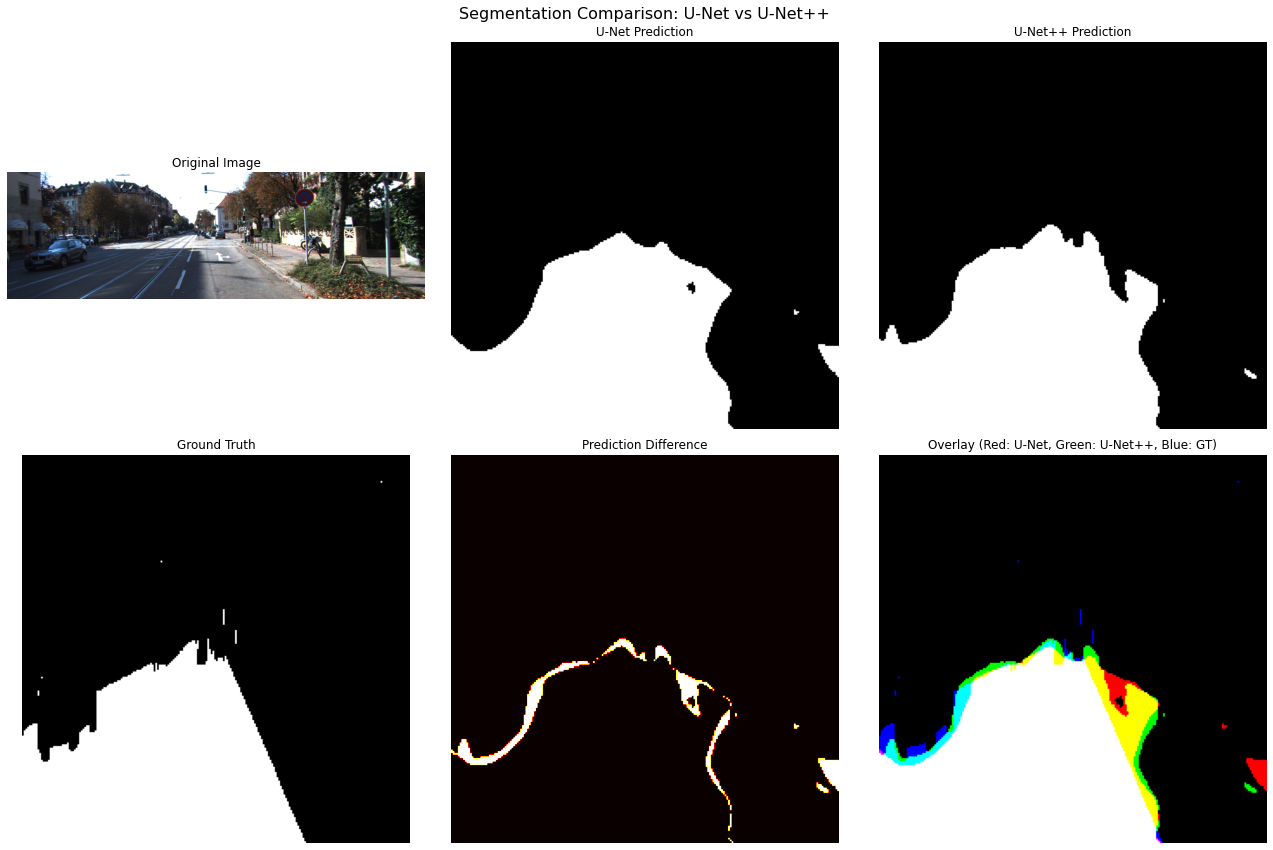


=== IoU Comparison ===
IoU : 0.854593
IoU : 0.876832
U-Net IoU: 0.8546
U-Net++ IoU: 0.8768
Improvement: 0.0222 (2.60%)

📈 2. Comprehensive Performance Analysis
=== Comprehensive Comparison: U-Net vs U-Net++ ===
Analyzing 10 test images...
Image  1: U-Net IoU: 0.8546, U-Net++ IoU: 0.8768, Improvement: +0.0222
Image  2: U-Net IoU: 0.6404, U-Net++ IoU: 0.6631, Improvement: +0.0228
Image  3: U-Net IoU: 0.6205, U-Net++ IoU: 0.7230, Improvement: +0.1025
Image  4: U-Net IoU: 0.7172, U-Net++ IoU: 0.7746, Improvement: +0.0574
Image  5: U-Net IoU: 0.7490, U-Net++ IoU: 0.7205, Improvement: -0.0284
Image  6: U-Net IoU: 0.5618, U-Net++ IoU: 0.7974, Improvement: +0.2356
Image  7: U-Net IoU: 0.8350, U-Net++ IoU: 0.7207, Improvement: -0.1142
Image  8: U-Net IoU: 0.7678, U-Net++ IoU: 0.7691, Improvement: +0.0013
Image  9: U-Net IoU: 0.8089, U-Net++ IoU: 0.7337, Improvement: -0.0752
Image 10: U-Net IoU: 0.8027, U-Net++ IoU: 0.7096, Improvement: -0.0931

=== Summary Statistics ===
Total images analyzed:

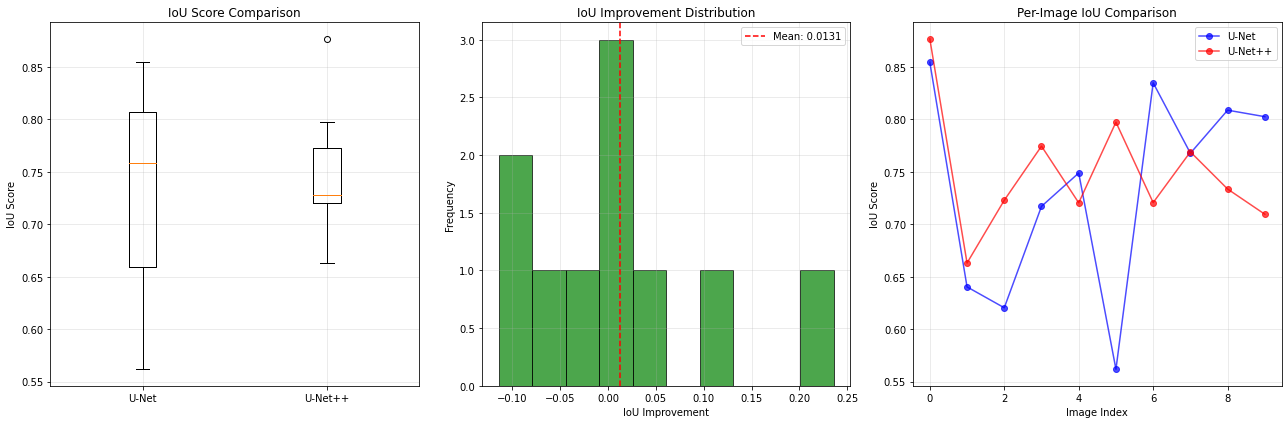

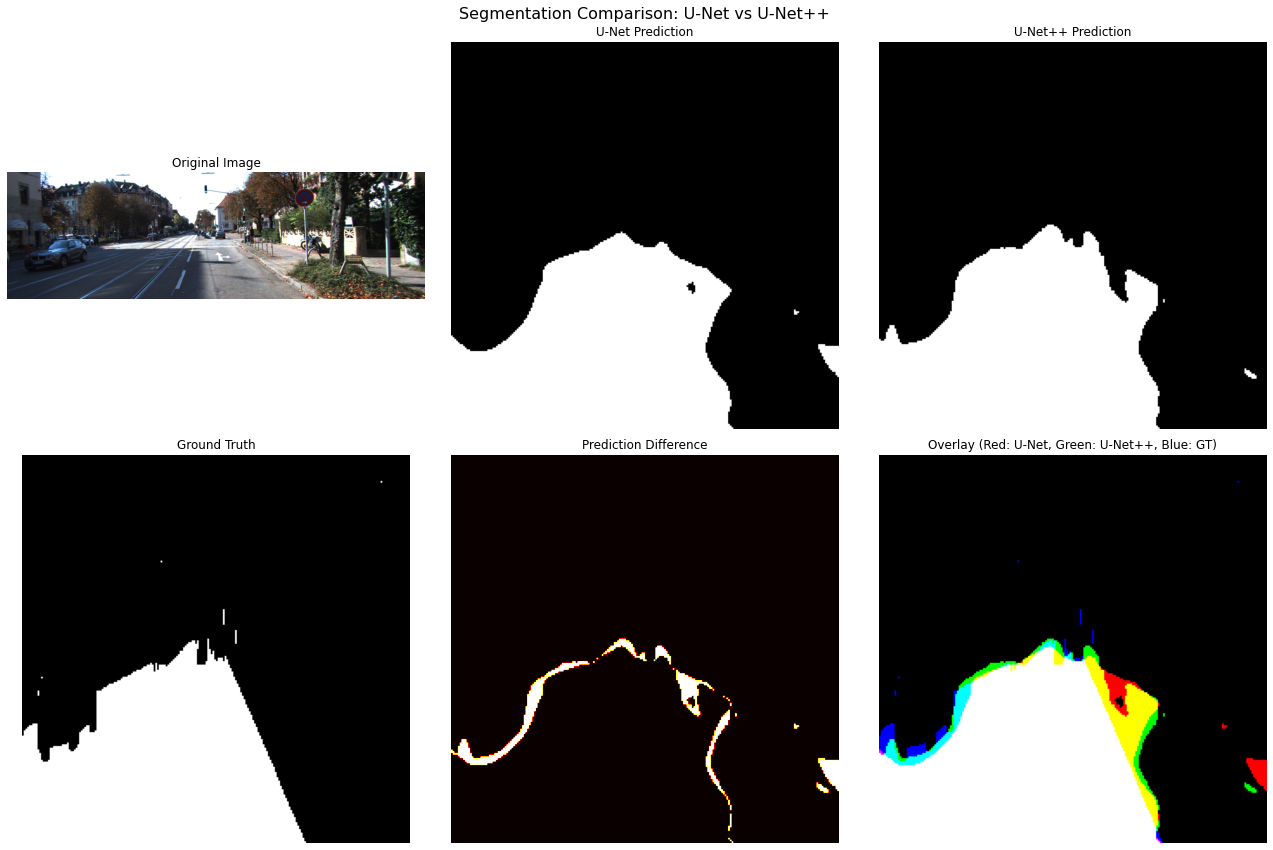


=== IoU Comparison ===
IoU : 0.854593
IoU : 0.876832
U-Net IoU: 0.8546
U-Net++ IoU: 0.8768
Improvement: 0.0222 (2.60%)


{'U-Net_IoU': 0.8545931014944401,
 'U-Net++_IoU': 0.8768320180383314,
 'Improvement': 0.02223891654389132,
 'Improvement_Percentage': 2.6022813084966145}

In [11]:
# 기존 변수들 사용 (model1=U-Net, model2=U-Net++)
single_result, comprehensive_result = run_comparison_example(
    model1=model1,
    model2=model2, 
    preproc=test_preproc,
    dir_path=dir_path
)

# 또는 개별 이미지만 비교
i = 1  # 원하는 이미지 번호
compare_models_visualization(
    model1, model2, test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
)

#### 회고
- 결과 분석
    - 평균 3.44% 개선으로 전반적 성능 향상
    - 표준편차가 -0.04로 더 일관된 성능
    - 10개 중 6개 케이스에서  U-Net++ 우위
- 케이스별 특성으로 복잡한 도로 구조에서 U-Net++가 더 좋고, 단순한 경우엔 차이가 적음
- 논문(3.9 포인트)과 실제(1.31 포인트)의 차이 원인
    - 데이터셋 차이 (의료 영상 vs. KITTI 도로 세그멘테이션, 근본적 차이)
    - Deep Supervision 차이 (다중 출력 + 앙상블 효과 vs. 단일 출력)
    - task 특성 (더 세밀한 구조, 다양한 스케일의 객체 vs. 상대적으로 단순한 이진 분류)
    - 학습 데이터 양 (각 데이터셋별로 충분한 양 vs. KITTI 일부(train/test split)만 사용)
    - 배치 크기 (우리는 4, 논문이 아마 더 클 것)

#### 번외

In [ ]:
# ================================
# KITTI Dataset Generator for U-Net++
# Deep Supervision 지원
# ================================

import tensorflow as tf
import numpy as np
import math
from glob import glob
import os
from tensorflow.keras.utils import Sequence

class KittiGeneratorUNetPlusPlus(tf.keras.utils.Sequence):
    '''
    U-Net++의 Deep Supervision을 지원하는 KITTI Generator
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None,
                 deep_supervision=True,
                 num_outputs=4):  # U-Net++의 출력 개수
        
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        self.deep_supervision = deep_supervision
        self.num_outputs = num_outputs
        
        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
        
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[index*self.batch_size:(index + 1)*self.batch_size]
        
        inputs = np.zeros([self.batch_size, *self.img_size])
        
        if self.deep_supervision:
            # Deep supervision: 다중 출력을 위한 타겟 리스트
            outputs = [np.zeros([self.batch_size, *self.output_size, 1]) for _ in range(self.num_outputs)]
        else:
            # 단일 출력
            outputs = np.zeros([self.batch_size, *self.output_size, 1])
            
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = tf.keras.preprocessing.image.load_img(input_img_path, target_size=self.img_size[:2])
            _input = tf.keras.preprocessing.image.img_to_array(_input)
            
            _output = tf.keras.preprocessing.image.load_img(output_path, target_size=self.output_size, color_mode='grayscale')
            _output = tf.keras.preprocessing.image.img_to_array(_output)
            _output = (_output == 7).astype(np.uint8) * 1  # 도로 클래스만 추출
            
            if self.augmentation:
                data_aug = {
                    "image": _input.astype(np.uint8),
                    "mask": _output.astype(np.uint8),
                }
                augmented = self.augmentation(**data_aug)
                _input = augmented["image"]
                _output = augmented["mask"]
            
            inputs[i] = _input / 255.0  # 정규화
            
            if self.deep_supervision:
                # 모든 출력에 동일한 타겟 할당
                for j in range(self.num_outputs):
                    outputs[j][i] = _output / 255.0
            else:
                outputs[i] = _output / 255.0
        
        return inputs, outputs

    def on_epoch_end(self):
        if self.is_train:
            np.random.shuffle(self.data)

# ================================
# U-Net++ 학습을 위한 헬퍼 함수들
# ================================

def create_kitti_generators(data_path, augmentation=None, deep_supervision=True):
    """
    KITTI 데이터셋을 위한 train/test generator 생성
    """
    train_gen = KittiGeneratorUNetPlusPlus(
        data_path,
        batch_size=16,
        is_train=True,
        augmentation=augmentation,
        deep_supervision=deep_supervision,
        num_outputs=4  # U-Net++의 기본 출력 개수
    )
    
    test_gen = KittiGeneratorUNetPlusPlus(
        data_path,
        batch_size=16,
        is_train=False,
        augmentation=None,  # Test에는 augmentation 없음
        deep_supervision=deep_supervision,
        num_outputs=4
    )
    
    return train_gen, test_gen

def train_unet_plus_plus_kitti(model, train_gen, test_gen, epochs=100):
    """
    U-Net++를 KITTI 데이터셋으로 학습
    """
    # 콜백 설정
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'unet_plus_plus_kitti_best.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # 학습 시작
    history = model.fit(
        train_gen,
        validation_data=test_gen,
        epochs=epochs,
        steps_per_epoch=len(train_gen),
        validation_steps=len(test_gen),
        callbacks=callbacks,
        verbose=1
    )
    
    return history

# ================================
# 예측 및 평가 함수들
# ================================

def predict_single_image(model, image_path, deep_supervision=True):
    """
    단일 이미지에 대한 예측
    """
    # 이미지 로드 및 전처리
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # 예측 수행
    predictions = model.predict(img_array, verbose=0)
    
    if deep_supervision:
        # Deep supervision: 여러 출력의 평균
        ensemble_pred = np.mean(predictions, axis=0)
        return ensemble_pred[0]  # 배치 차원 제거
    else:
        return predictions[0]

def evaluate_model_performance(model, test_generator, deep_supervision=True):
    """
    모델 성능 평가
    """
    total_iou = 0
    total_dice = 0
    num_batches = 0
    
    for batch_x, batch_y in test_generator:
        predictions = model.predict(batch_x, verbose=0)
        
        if deep_